In [1]:
!pip install parameter-sherpa

Processing /home/jovyan/.cache/pip/wheels/96/d9/cb/99569566e5e9b3ef0265ba4cbce3ff16f7692988833aa942f5/parameter_sherpa-1.0.6-py2.py3-none-any.whl
Processing /home/jovyan/.cache/pip/wheels/e6/fa/d1/f9652b5af79f769a0ab74dbead7c7aea9a93c6bc74543fd3ec/GPyOpt-1.2.6-py3-none-any.whl
Processing /home/jovyan/.cache/pip/wheels/e4/05/38/b84c6bec7ea9dc623cdbdb6203b55b3abe7a7020a992f2064c/GPy-1.9.9-cp37-cp37m-linux_x86_64.whl


In [1]:
import sherpa

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
data = pd.read_csv("owid-covid-data.csv")
data = data[data.iso_code=="FRA"]
data = data[data.date>='2020-04-01'] # primeiro caso computado
data.reset_index(inplace=True)

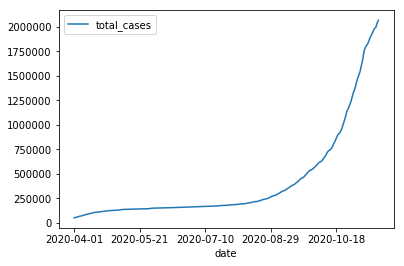

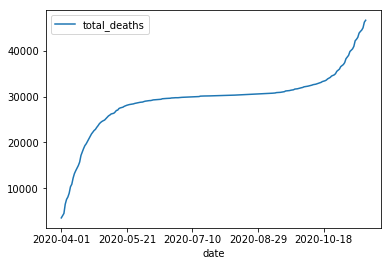

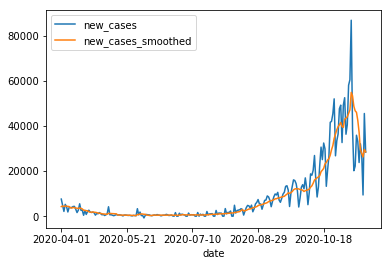

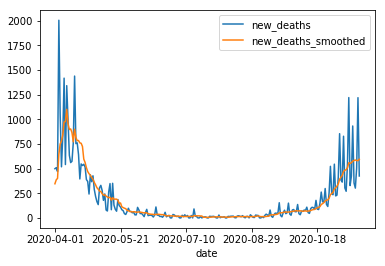

In [4]:
data.set_index('date')[['total_cases']].plot()
data.set_index('date')[['total_deaths']].plot()
data.set_index('date')[['new_cases','new_cases_smoothed']].plot()
data.set_index('date')[['new_deaths','new_deaths_smoothed']].plot()
popFRA = 67*10^6 

In [5]:
def ODE (t,y,params):
    S,E,I,A,R,D = y
    lambda_,alpha,p,theta,gamma, mu,mu1,mu2, t1,t2 = params

    # transição de mu1 para mu2, mudança de perfil dos infectados, com inflexão em t2, flexibilização do Lockdown
    mu = ( ( (np.tanh(-t + t2) + 1 )/2 ) * abs(mu1 - mu2) ) + mu2
    
    # período de isolamento com queda de lambda_ com inflexões em t1 e t2, início e fim do lockdown respectivamente
    lambda_ = 1 - ((1 + np.tanh(t - t1)) / 2) * ((1 - np.tanh(t - t2) / 2) )
    
    return [-lambda_*S*I,
            lambda_*S*I - alpha*E,
            (1-p)*alpha*E - gamma*I - mu*I,
            p*alpha*E - theta*A,
            gamma*I + theta*A,
            mu*I ]

In [6]:
T = ode_solver()
T.function = ODE
T.algorithm='rk8pd'
inits = [.95, 0,.05, 0, 0, 0]
tspan = [0,len(data)]
T.ode_solve(tspan, inits, num_points=50 + len(data), params=[0.4,0.5,0.2,0.3,0.5,0.3,0.5,0.3,54,109])

In [7]:
T.solution[0][1][0]

0.990000000000000

In [8]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[9.90000000e-01, 0.00000000e+00, 1.00000000e-03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [9.89422410e-01, 4.62552212e-04, 5.08435667e-04, 2.10598255e-05,
        2.93745191e-04, 2.91797400e-04],
       [9.89086338e-01, 5.78315254e-04, 3.44960410e-04, 5.56599140e-05,
        4.73067793e-04, 4.61658403e-04],
       ...,
       [9.85378094e-01, 3.37924951e-33, 2.18513404e-33, 6.17801905e-29,
        3.27314373e-03, 2.34876249e-03],
       [9.85378094e-01, 2.91041020e-33, 1.88196710e-33, 4.82594196e-29,
        3.27314373e-03, 2.34876249e-03],
       [9.85378094e-01, 2.50661796e-33, 1.62086173e-33, 3.76977264e-29,
        3.27314373e-03, 2.34876249e-03]])

In [9]:
parameters = [
    sherpa.Continuous(name='lambda_',range=[.1,2]), 
    sherpa.Continuous(name='alpha',range=[.01,1]), 
    sherpa.Continuous(name='p',range=[.2,1]),
    sherpa.Continuous(name='theta',range=[.01,1]),
    sherpa.Continuous(name='gamma',range=[.2,1]),
    sherpa.Continuous(name='mu',range=[.01,.7]),
    sherpa.Continuous(name='mu1',range=[.01,.7]),
    sherpa.Continuous(name='mu2',range=[.01,.7]),
    sherpa.Discrete(name='t2',range=[105,115]), # quando a flexibilização afetou a dinâmica
    sherpa.Discrete(name='t1',range=[50,60]), # quando o isolamento afetou a dinâmica 
]
algorithm = sherpa.algorithms.RandomSearch(max_num_trials=1000)

In [10]:
study = sherpa.Study(parameters=parameters,
                     algorithm=algorithm,
                     lower_is_better=True,
                     disable_dashboard=True)

In [11]:
trial = study.get_suggestion()
trial.parameters

{'lambda_': 0.1840183522613955,
 'alpha': 0.6744609174262872,
 'p': 0.5222191733291814,
 'theta': 0.48301509412190435,
 'gamma': 0.2077399476974204,
 'mu': 0.42629527907198667,
 'mu1': 0.25018057543852745,
 'mu2': 0.07387586354401617,
 't2': 105,
 't1': 57}

In [12]:
for trial in study:
    pars = [trial.parameters[n] for n in ['lambda_', 'alpha','p','theta','gamma', 'mu','mu1','mu2','t1','t2' ]]
    
    T.ode_solve(tspan, inits, num_points=len(data), params=pars)
    sim = get_sim_array(T.solution)
    
    I = sim[:,-4]
    D = sim[:,-1]
    
    SEQcases = sum( ( data.total_cases/popFRA - I[ : len(data)] )**2 ) /2*len(data)
    SEQdeaths = sum( ( data.total_deaths/popFRA - D[ : len(data)] )**2 ) /2*len(data)
    
    
    study.add_observation(trial=trial,
                          objective=SEQcases + SEQdeaths,
                          )
    study.finalize(trial)

In [13]:
res = study.get_best_result()
res

{'Trial-ID': 157,
 'Iteration': 1,
 'alpha': 0.8747063934882114,
 'gamma': 0.4356390163374433,
 'lambda_': 0.488379159517525,
 'mu': 0.3117504981624227,
 'mu1': 0.08970242761406942,
 'mu2': 0.06738752736783678,
 'p': 0.6470349777399297,
 't1': 53,
 't2': 111,
 'theta': 0.6401286653453495,
 'Objective': 2.42483414161591}

In [19]:
def plot_results(pars):
    
    T.ode_solve(tspan, inits, num_points= len(data), params = list(pars) )
    sim = get_sim_array(T.solution)
    
    i = list_plot(sim[:len(data),-2],color='red',legend_label='I', plotjoined=True)
    d = list_plot(sim[:len(data),-1],color='purple', legend_label='D', plotjoined=True)
    
    cases = list_plot(list(zip(range(1,len(data)),data.total_cases/popFRA)), color='black',legend_label='cases(obs)')
    deaths = list_plot(list(zip(range(1,len(data)),data.total_deaths/popFRA)), color='orange',legend_label='deaths(obs)')
    
    show(i+cases)
    show(d+deaths)

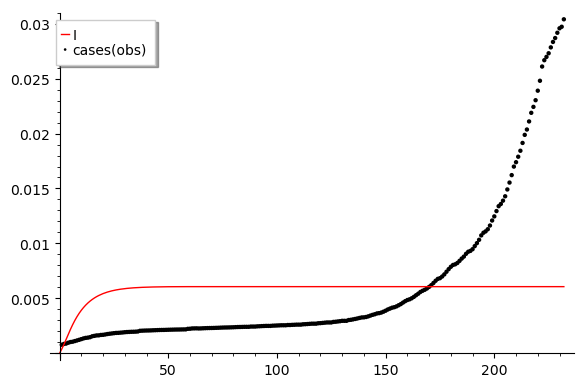

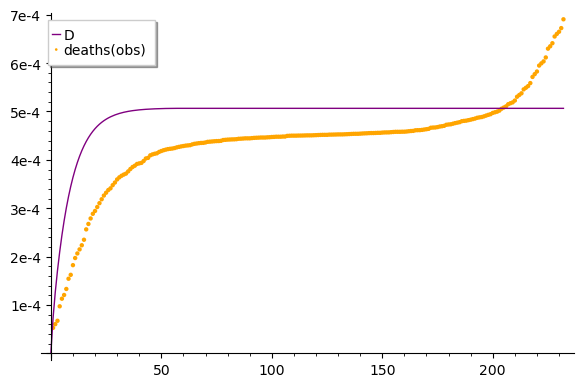

In [20]:
plot_results([res['lambda_'],
              res['alpha'],
              res['p'],
              res['theta'],
              res['gamma'],
              res['mu'],
              res['mu1'],
              res['mu2'],
              res['t1'],
              res['t2'],
             ])

In [16]:
#plt.savefig('sherpa.png')

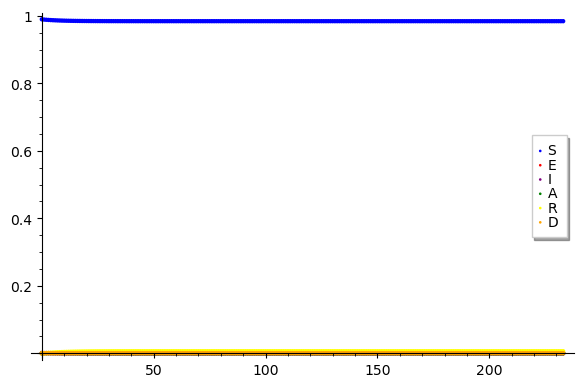

In [18]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='S')
    colors = ['blue','red','purple','green','yellow','orange']
    for i,var in enumerate(['E','I','A','R','D']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P)
plot_sol(T.solution)